### 6.Linear SVM

In [63]:
import os
import torch
import torch.nn as nn
from torchvision.models import alexnet
from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
print('device', device)


device cuda


### 1) CNN model load

In [51]:
# cnn model load
model = alexnet()
num_classes = 2
num_features = model.classifier[6].in_features   # 4096
print('num_features', num_features)

print(model.classifier)


num_features 4096
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [52]:
model.classifier[6] = nn.Linear(num_features, num_classes)
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [53]:
# weight load
chechkpoint_path = '../R-CNN/models/cnn_finetune/alexnet_car.pt'
model.load_state_dict(torch.load(chechkpoint_path))
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [54]:
# weight train하지 않도록
for param in model.parameters():
    param.requires_grad = False

### 2) SVM 만들기

In [55]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [56]:
model.classifier[6] = nn.Linear(num_features, num_classes)

In [57]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [58]:
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [61]:
summary(model, (64, 3, 256,256))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [64, 2]                   --
├─Sequential: 1-1                        [64, 256, 7, 7]           --
│    └─Conv2d: 2-1                       [64, 64, 63, 63]          (23,296)
│    └─ReLU: 2-2                         [64, 64, 63, 63]          --
│    └─MaxPool2d: 2-3                    [64, 64, 31, 31]          --
│    └─Conv2d: 2-4                       [64, 192, 31, 31]         (307,392)
│    └─ReLU: 2-5                         [64, 192, 31, 31]         --
│    └─MaxPool2d: 2-6                    [64, 192, 15, 15]         --
│    └─Conv2d: 2-7                       [64, 384, 15, 15]         (663,936)
│    └─ReLU: 2-8                         [64, 384, 15, 15]         --
│    └─Conv2d: 2-9                       [64, 256, 15, 15]         (884,992)
│    └─ReLU: 2-10                        [64, 256, 15, 15]         --
│    └─Conv2d: 2-11                      [64, 256, 15, 15]

### 3) 학습 결과

In [62]:
import numpy as np
import matplotlib.pyplot as plt

In [74]:
models_path = '../R-CNN/models/linear_svm'

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for i in range(0, 10):
    checkpoint_file = f'linear_svm_alexnet_car_{i+1}.pt'
    checkpoint_path = os.path.join(models_path, checkpoint_file).replace('\\', '/')
    print(checkpoint_path, (os.path.isfile(checkpoint_path)))
    
    checkpoint = torch.load(checkpoint_path, map_location= device)
    train_loss_list.append(checkpoint['train_loss'])
    val_loss_list.append(checkpoint['val_loss'])
    train_acc_list.append(checkpoint['train_acc'].cpu().numpy())
    val_acc_list.append(checkpoint['val_acc'].cpu().numpy())
    

../R-CNN/models/linear_svm/linear_svm_alexnet_car_1.pt True
../R-CNN/models/linear_svm/linear_svm_alexnet_car_2.pt True
../R-CNN/models/linear_svm/linear_svm_alexnet_car_3.pt True
../R-CNN/models/linear_svm/linear_svm_alexnet_car_4.pt True
../R-CNN/models/linear_svm/linear_svm_alexnet_car_5.pt True
../R-CNN/models/linear_svm/linear_svm_alexnet_car_6.pt True
../R-CNN/models/linear_svm/linear_svm_alexnet_car_7.pt True
../R-CNN/models/linear_svm/linear_svm_alexnet_car_8.pt True
../R-CNN/models/linear_svm/linear_svm_alexnet_car_9.pt True
../R-CNN/models/linear_svm/linear_svm_alexnet_car_10.pt True


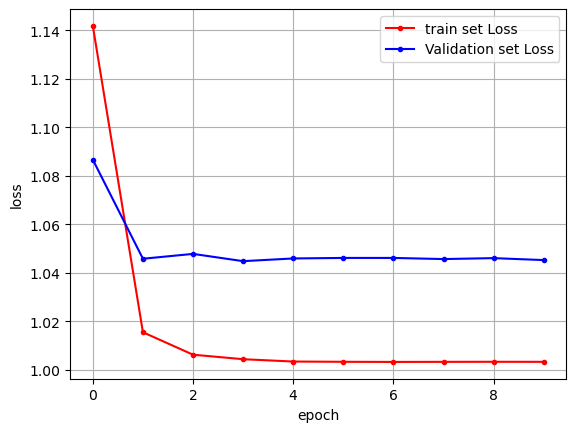

In [75]:
x_len = np.arange(len(train_loss_list))


plt.plot(x_len, train_loss_list, marker='.', c='red', label="train set Loss")
plt.plot(x_len, val_loss_list, marker='.', c='blue', label="Validation set Loss")
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

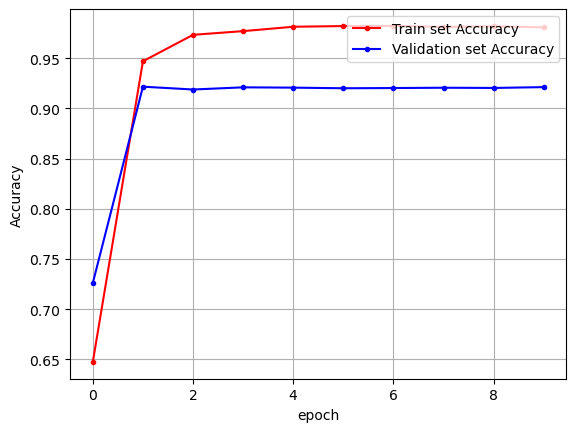

In [76]:
x_len = np.arange(len(train_loss_list))


plt.plot(x_len, train_acc_list, marker='.', c='red', label="Train set Accuracy")
plt.plot(x_len, val_acc_list, marker='.', c='blue', label="Validation set Accuracy")
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()